<a href="https://colab.research.google.com/github/VladPrytula/deep-reinforcement-learning-journey/blob/main/colab_reinforcement_learning_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 4: Reinforcement Learning

© Deep Learning Indaba. Apache License 2.0.

## Introduction

In this practical, we first explore the reinforcement learning problem using the [OpenAI Gym](https://gym.openai.com/) reinforcement learning environments. We will then build agents that control the environments in three different ways:
1. An agent that takes random actions
2. A neural net agent trained with random search
3. A neural net agent trained using a policy gradient algorithm

In [1]:
#@title Imports (RUN ME!)


# Note: enviroments like CartPole-v0 require a display to render. We need to install pyvirtualdisplay etc 
# in order to render from these environments

!sudo apt-get update
!pip install pyglet
# !pip install 'gym[atari]' > /dev/null 2>&1
!pip install --upgrade gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install tensorflow
!pip install pygame
!pip install gym[classic_control]
!pip install gym[atari]
!pip install gym[accept-rom-license]

from IPython.display import HTML

# Start virtual display
from pprint import pprint
import logging
from pyvirtualdisplay import Display
logging.getLogger("pyvirtualdisplay").setLevel(logging.ERROR)
import os
display = Display(visible=0, size=(1024, 768))
display.start()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [816 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

## The Reinforcement Learning Problem

So far we have encountered **supervised learning**, where we have an input and a target value or class that we want to predict. We have also encountered **unsupervised learning** where we are only given an input and look for patterns in that input. In this practical, we look into **reinforcement learning**, which can loosely be defined as training an **agent** to maximise the total **reward** it obtains through many interactions with an **environment**.

The agent can make an **observation** of the environment $o_t$. For example, if the environment is a computer game, the observation could be the the pixel values of the current screen.

The environment defines a set of **actions** that an agent can take.  The agent performs an action $a_t$ informed by the observations it has made, and will receive a **reward** $r_t$ from the environment after every action. The *reinforcement learning problem* is to find an agent whose actions maximize the total rewards obtained from the environment over many actions.

The following diagram illustrates the interaction between the agent and environment. We will explore each of the terms in more detail throughout this practical.

<!-- ![Interaction of Agent and Environment](https://github.com/sbodenstein/Tutorials/blob/master/indaba_2019/Images/RL_Environment.png?raw=true) -->

<img src="https://raw.githubusercontent.com/sbodenstein/Tutorials/master/indaba_2019/Images/RL_Environment.png" alt="drawing" width=600/>



**Optional Recommended Reading**: 
- [*OpenAI Spinning Up: Key Concepts in RL*](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) is a great summary of the terminology used in reinforcement learning. We will follow the notation used by OpenAI Spinning Up.

### The Environment

We will focus on the cartpole environment for this practical. This environment consists of a pole attached to a cart via a hinge, with the pole initially balanced close to upright. The agent can move the cart to the left or to the right in order to prevent the pole from falling down.

![CartPole Illustration](https://user-images.githubusercontent.com/10624937/42135683-dde5c6f0-7d13-11e8-90b1-8770df3e40cf.gif)


We will use the OpenAI Gym implementation of the cartpole environment. [OpenAI Gym](https://gym.openai.com/) is probably the most popular set of Reinforcement Learning environments (the available environments in Gym can be seen [here](https://gym.openai.com/envs)). Every Gym environment has the same interface, allowing code written for one environment to work for all of them. Popular reinforcement learning frameworks, such as [Ray](https://ray.readthedocs.io/en/latest/index.html), often use the Gym interface as [their default interface](https://ray.readthedocs.io/en/latest/rllib-env.html#openai-gym) for reinforcement learning environments.

Let us import Gym and open a cartpole environment:

In [3]:
import numpy as np
import gym
env_cartpole = gym.make('CartPole-v1')

/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


The first step to using a Gym environment is to initialize the environment to some initial state using the `reset` method. The `reset` method also returns the first observation of the environment:

In [4]:
env_cartpole.reset()

array([ 0.02133307, -0.02611597, -0.03022016, -0.0214833 ], dtype=float32)

These four numbers represent the position and velocity of the cart and pole. We will want our agent to use this observation to inform its actions.

**Question**: is there any difference between the observation and state of the cartpole environment? (**Hint**: is any more information required to describe the system?)

 But we also want to see an image of the system that we can interpret. Gym provides the `render` method to do this:

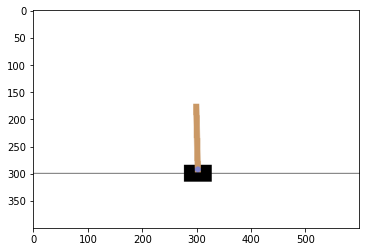

In [5]:
import matplotlib.pyplot as plt
plt.imshow(env_cartpole.render(mode='rgb_array'));

Note that re-initializing this environment with `reset` will change its initial state. Cartpole starts with slighty different angles when we reset. By running this multiple times, see if you can notice:

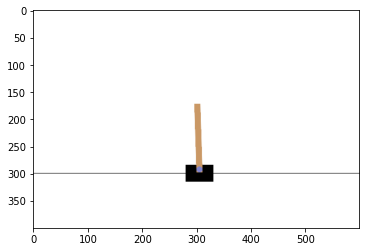

In [6]:
env_cartpole.reset()
plt.imshow(env_cartpole.render(mode='rgb_array'));

Now we want to take an action using the `step` method. But which actions are allowed, and how are they represented? We can find this out using the `action_space` property of Gym environments:

In [7]:
env_cartpole.action_space

Discrete(2)

In Gym, `Discrete(n)` means actions are represented by the integers `0,1,...,n-1`. Action spaces always provide a way to take a random action sampled from the space:

In [8]:
[env_cartpole.action_space.sample() for _ in range(10)]

[1, 0, 1, 1, 1, 1, 0, 1, 1, 1]

Now let us take an action using the `step` method, which takes an action and returns a tuple `(observation, reward, done, info)`:

In [9]:
action = 1
env_cartpole.step(action)

(array([ 0.04449991,  0.1603869 , -0.03456115, -0.34711483], dtype=float32),
 1.0,
 False,
 {})

**Exercise**: work out whether the action `0` moves the cart to the left or to the right by using the `step` and `render` methods.

1.   List item
2.   List item



**Solution**: use the `render` method to see what happens when `step` is called with the `0` action. Should find that the action `0` moves the cart to the left.

What is `done`? Many environments are **episodic**, which means they have a natural end-point, after which more actions cannot be taken. For example in chess, the game ends after a checkmate. In the case of cart-pole, this end-point is when the pole falls down too far. Then no matter the actions taken, the pole will keep falling. Gym will set `done` as `True` in this case, and will print a warning if `step` is called again. The `reset` method needs to be called to re-initialize the environment when `done` is `True`.  We won't use `info` (see the [official Gym docs](https://gym.openai.com/docs/#observations) for more information).

Note that the reward is always `1.0` for every step taken in cartpole before `done` is `True`.

**Exercise**: *Thinking about rewards*. What is an appropriate reward for a game of chess? Suppose the environment is one where your agent plays against an existing chess-playing agent, either human or machine. Remember that there are three outcomes in chess, a win, loss and draw.

**Exercise**: Write a function `actions_till_done(env, act)` that takes an environment `env` and action `act`, reinitializes `env` with `reset`, and returns the number of actions taken before `done` is `True`. If you always take the `0` action, how many steps can you take on average before `done` is `True`?



#### Solution:

In [10]:
def actions_till_done(env, action):
    env.reset()
    done = False
    count = 0
    while done == False:
        _, _, done, _, = env.step(action)
        count += 1
    return count

In [11]:
# Get an estimate for how many 0 actions you can take on average before the 
# pole falls over
np.mean([actions_till_done(env_cartpole, 0) for _ in range(100)])

9.34

## Agents and Policies

A **policy** is a function used by an agent to decide what actions to take. This function takes as input an observation and returns either an action (a **deterministic policy**) or a probability distribution over possible actions (a **stochastic policy**).

**Note**: the terms **policy** and **agent** are often used interchangeably:
> Because the policy is essentially the agent’s brain, it’s not uncommon to substitute the word “policy” for “agent”, eg saying “The policy is trying to maximize reward.” ~ [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#policies)

We will consider an **agent** to be a function whose input is the observation, and it returns a dictionary which always contains the `"Action"` key. It might also contain other keys, such as the action probabilities, the value function, etc. 

The simplest possible policy for a cartpole agent is one that always takes the `0` action, no matter what the observation is:

In [12]:
def agent_left(observation):
    return {"Action":0}

In [13]:
agent_left(None)

{'Action': 0}

### Rewards and Returns

Is our agent `agent_left` any good? To answer that, we need some measure of 'goodness', which is usually related to the total obtained during an episode. This is called the **return**, $R$, and there are different ways of defining it. The most obvious definition for return is to simply add up all the rewards the agent received during an episode. If the episode took $T$ steps, and got a reward $r_t$ at each step, then this return is $R = \sum_{t=1}^{T} r_{t}$, where $r_t$ is the reward received at timestep $t$.

One issue is that some environments will have different initial states, and some agents take actions stochastically. The solution is to average the returns over multiple starting points. Here is a function that does this:

In [14]:
def average_episodic_return(env, agent, episodes=10, max_steps_per_episode=1000):
    epoch_rewards = []
    for episode in range(episodes):
        total_rewards = 0
        obs = env.reset()
        for t in range(max_steps_per_episode):
            out = agent(obs) # we don't care about the probabilities here
            assert ("Action" in out), "The key 'Action' was missing from the agents output."
            obs, rew, done, _ = env.step(out["Action"])
            total_rewards += rew
            # check if we are done, if so, exit loop
            if done:
                break
                
        epoch_rewards.append(total_rewards)
        
    return {
        "AverageEpisodicReturn": np.mean(epoch_rewards), 
        "StandardDeviation":np.sqrt(np.var(epoch_rewards))
    }

Now we can see how good our agent `agent_left` is:

In [15]:
average_episodic_return(env_cartpole, agent_left)

{'AverageEpisodicReturn': 9.2, 'StandardDeviation': 0.9797958971132711}

**Question**: the implementation of `average_episodic_return` has the optional parameter `max_steps_per_episode`. What does it do, and why is it there? (**Hint**: think of agents that are **too good** at controlling cartpole)

### Animating Agents

**We suggest cell without understanding the implementation.** This code cell defines a function `animate_agent(environment, agent)` that produces a human understandable animation of the `agent` controlling the `environment`:

In [16]:
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
%matplotlib inline

def animate_agent(env, agent, max_steps = 400):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break
            
    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)
    
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])
    
    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)
    
    plt.close()
    return HTML(ani.to_jshtml())

Now we can easily get an animation of the cartpole environment controlled by `policy_left`:

In [17]:
def agent_left(observation):
    return {"Action":0}
  
animate_agent(env_cartpole, agent_left, max_steps = 400)

## Agent 1: Random Action Agent

Rather than having an agent whose policy is to always take the same action, we could also randomly choose between possible actions

**Question**: would you expect the agent taking random actions to get a higher or lower return than the `agent_left` agent for cartpole?

In [18]:
def agent_random(observation):
    return {"Action":np.random.choice([0, 1])}

**Note**: that we can easily write a general random agent for any gym environment using `env.action_space.sample()`. 

Computing the average return of `agent_random`:

In [19]:
average_episodic_return(env_cartpole, agent_random)

{'AverageEpisodicReturn': 19.7, 'StandardDeviation': 8.798295289429651}

And animating it:

In [20]:
animate_agent(env_cartpole, agent_random)

**Exercise**: create a random agent for "MsPacman-v0" environment using `env.action_space.sample()` and animate the agent using `animate_agent` for 300 steps:



#### Solution:

In [22]:
!pip install gym[accept-rom-license]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=87a9af13809c941face9914fdced1e0d36e873ebd44c92e47913b8d1cd2f8127
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [24]:
for name in gym.envs.registry.all():
  print(name.id)

ALE/Tetris-v5
ALE/Tetris-ram-v5
Adventure-v0
AdventureDeterministic-v0
AdventureNoFrameskip-v0
Adventure-v4
AdventureDeterministic-v4
AdventureNoFrameskip-v4
Adventure-ram-v0
Adventure-ramDeterministic-v0
Adventure-ramNoFrameskip-v0
Adventure-ram-v4
Adventure-ramDeterministic-v4
Adventure-ramNoFrameskip-v4
AirRaid-v0
AirRaidDeterministic-v0
AirRaidNoFrameskip-v0
AirRaid-v4
AirRaidDeterministic-v4
AirRaidNoFrameskip-v4
AirRaid-ram-v0
AirRaid-ramDeterministic-v0
AirRaid-ramNoFrameskip-v0
AirRaid-ram-v4
AirRaid-ramDeterministic-v4
AirRaid-ramNoFrameskip-v4
Alien-v0
AlienDeterministic-v0
AlienNoFrameskip-v0
Alien-v4
AlienDeterministic-v4
AlienNoFrameskip-v4
Alien-ram-v0
Alien-ramDeterministic-v0
Alien-ramNoFrameskip-v0
Alien-ram-v4
Alien-ramDeterministic-v4
Alien-ramNoFrameskip-v4
Amidar-v0
AmidarDeterministic-v0
AmidarNoFrameskip-v0
Amidar-v4
AmidarDeterministic-v4
AmidarNoFrameskip-v4
Amidar-ram-v0
Amidar-ramDeterministic-v0
Amidar-ramNoFrameskip-v0
Amidar-ram-v4
Amidar-ramDeterministic-

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:397: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  "The `registry.all` method is deprecated. Please use `registry.values` instead."


In [26]:
env_pacman = gym.make("TimePilot-v4")
def pacman_agent(obs):
    return {"Action":env_pacman.action_space.sample()}
an = animate_agent(env_pacman, pacman_agent, max_steps=300)
env_pacman.close()
an

Error: ignored

## Agent 2: Neural Net Policy Trained with Random Search

To improve on the random agent `agent_random`, we need a policy that takes the observation of the environment into account. In this section, we will show how to create an agent that solves the cartpole problem without any fancy reinforcement learning methods.

Define an agent with a single hidden-layer multi-layer perceptron (MLP) policy implemented using NumPy. Its input is a vector of length 4 and its output is either `0` or `1`:

In [ ]:
class AgentMLPNumpy:
    def __init__(self, num_hidden):
        self.W1 = np.random.randn(num_hidden, 4)
        self.W2 = np.random.randn(2, num_hidden)
        
    def __call__(self, x):
        y = self.W1.dot(x)
        y = np.tanh(y)
        y = self.W2.dot(y)
        return {"Action":np.argmax(y)}

We will train this agent in the following way: create many instances of `PolicyMLPNumpy` with different random initializations, and compute their returns. Then pick the one with the highest return:

In [ ]:
def find_good_mlp_agent(env, num_tries, mlp_size):
    best_return = 0
    for _ in range(num_tries):
        agent = AgentMLPNumpy(mlp_size)
        ret = average_episodic_return(env, agent, 4, max_steps_per_episode=200)["AverageEpisodicReturn"]
        if ret > best_return:
            best_agent = agent
            best_return = ret
    return best_agent, best_return

We can now try 100 policies with different initializations, and you should see one with the maximum return (200). If not, try running this a few times:

In [ ]:
agent_random_search, best_ret = find_good_mlp_agent(env_cartpole, 200, 15)
print("Best Return", best_ret)

Amazingly, this produces a policy which achieves a maximum reward! It probably tells us that cartpole is a very simple problem to solve. We can visualize this policy controlling the cartpole environment:

In [ ]:
animate_agent(env_cartpole, agent_random_search, max_steps = 200)

#### Optional Extra Reading

Variations of random search have proven to be very succesful for training agents to solve the reinforcement learning problem. Here are some examples:
- [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/blog/evolution-strategies/), OpenAI, 2017
- [Simple random search provides a competitive approach to reinforcement learning](https://arxiv.org/abs/1803.07055), H. Mania *et al*, 2018
- [Welcoming the Era of Deep Neuroevolution](https://eng.uber.com/deep-neuroevolution/), Uber AI Labs, 2017

Note that random search used to solve the *reinforcement learning problem* is not generally considered to be a *reinforcement learning method* (as implied by the titles of some of the readings above, eg. "Evolution Strategies as a Scalable Alternative to Reinforcement Learning"). The reason for this:

> Reinforcement learning, like many topics whose names end with “ing,” such as machine learning and mountaineering, is simultaneously a problem, a class of solution methods that work well on the problem, and the field that studies this problem and its solution methods. It is convenient to use a single name for all three things, but at the same time essential to keep the three conceptually separate. In particular, the distinction between problems and solution methods is very important in reinforcement learning; failing to make this distinction is the source of many confusions. ~ *Reinforcement Learning*, Sutton and Barto, **2nd Edition**

## Agent 3: Neural Net Agent Trained with Policy Gradients

Unlike the random policy, the MLP policy trained with random search *does* take environment observations into account when choosing to take an action. However, the training procedure is clearly not optimal: each policy in the search makes no use of observations and rewards seen by previous policies. For environments where it is costly to make observations, this is incredibly wasteful. In this section, we present a method that does take previous observations into account when learning.

**Warning**: This section requires more mathematics than previous sections, and hence more precise notation. It will thus feel a lot more abstract.

### Policy Gradient Theory

As we saw earlier, the reinforcement learning problem is to find an agent/policy that maximizes the return (rewards). We will now use a neural net to represent a stochastic policy  $\pi_\mathbf{\theta}(a_t|s_t)$, where $\mathbf{\theta}$ is the set of learnable parameters in the neural net, and $\pi_\mathbf{\theta}(a_t|s_t)$ is a probability distribution over the possible actions conditioned on the state/observation.

A **trajectory**  $\tau$ is a sequence of states/observations of the environment and the corresponding actions an agent takes. For an episodic task that ends after $T$ steps:
$$\tau = (s_0, a_0, s_1, a_1, \ldots , s_T, a_T)$$
The return (or total rewards) is a function of the trajectory, $R(\tau)$.

We want to find the values of $\theta$ that maximize the **expected return** over trajectories:
$$J(\pi_\theta)= \mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}[R(\tau)]$$

The usual way of efficiently finding good values of $\theta$ is to differentiate the objective with respect to $\theta$ and then use gradient descent. Luckily, we can obtain an *estimate* of this gradient. The key result is the *Policy Gradient Theorem*:
$$\nabla_\theta J(\pi_\theta) = 
\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}\left[ \sum_{t=0}^{T}\Phi_t\nabla_\theta\log \pi_\theta(a_t|s_t) \right] 
$$
There are many possibilities for $\Phi_t$ (see page 2 [here](https://arxiv.org/pdf/1506.02438.pdf) for a list of these possibilities). We  will use $\Phi_t = \hat{R}_t \equiv \sum_{t'=t}^{T} r_{t'}$, sometimes known as the [reward-to-go](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#don-t-let-the-past-distract-you). Note that $\mathop{\mathbb{E}} _{\tau \sim \pi_{\theta}}$ is an expectation over trajectories $\tau$ which can be estimated by using a sample mean. Let us call this estimate of the gradient $\hat{g}$:

$$\hat{g} = \frac{1}{|D|}\sum_{\tau \in \mathcal{D}}
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|s_t) 
$$
where $\mathcal{D}$ is a set of trajectories of size $|\mathcal{D}|$. The more trajectories we sample from, the lower the variance of the estimator $\hat{g}$. But to simplify things for this practical, we will only be sampling from only one trajectory at a time to get our gradient estimate. Then:
$$\hat{g} =
\sum_{t=0}^{T}\hat{R}_t\nabla_\theta\log \pi_\theta(a_t|s_t) 
$$
Translating this into a loss to be *maximized*:
$$\mathcal{L}=\sum_{t=0}^{T}\hat{R}_t\log \pi_\theta(a_t|s_t) $$

This looks very similar to the usual supervised learning cross-entropy loss, $\sum_{i}\log p(y_i|x_i) $, where $y_i$ is the label and $x_i$ is the feature. Indeed, learning with policy gradients is almost the same doing supervised learning with the following small changes:

- we use the action $a_t$ taken when we saw $s_t$ as the label ($y_i$)
- the loss of each example gets multiplied (or *weighted*) by $\hat{R}_t$. This increases the log probability for good actions and decrease it by bad actions.
- we are doing gradient *ascent* rather than the usual gradient *descent*

In summary:

| Reinforcement Learning         	|  Supervised Learning 	|
|-------------------------------------	|-----------------------------------------------------		|
|  $\sum_{t}\log \pi_\theta(a_t|s_t) \hat{R}_t$     	| $\sum_{i}\log p(y_i|x_i) $    |
|  action $a_t$    | label $y_i$    |
|  state $s_t$    | feature $x_i$    |
| $\pi_\theta(a_t|s_t)$   |   $p(y_i|x_i)$  |
|  gradient ascent     	|  gradient descent    |

For those interested in the derivation, there are two excellent resources:
- [Part 3: Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html) of OpenAI Spinning Up.
- Chapter 13 of Sutton and Barto, *Reinforcement Learning: and Introduction*, 2nd Edition. A free copy can be found [here](http://incompleteideas.net/book/RLbook2018.pdf).

The name "policy gradient" comes from the fact that we're directly taking the gradient of the policy, rather than the alternative, value-based RL, which uses iterative update rules to calculate the expected return assocated with a state. The particular flavour of policy gradient which uses the loss function above, along with the Monte-carlo approximation of the objective is known as the **REINFORCE** algorithm ([Williams 1992](https://link.springer.com/article/10.1007/BF00992696)).


**Note**:

> Reinforcement learning notation sometimes puts the symbol for state, $s$, in places where it would be technically more appropriate to write the symbol for observation, $o$. Specifically, this happens when talking about how the agent decides an action: we often signal in notation that the action is conditioned on the state, when in practice, the action is conditioned on the observation because the agent does not have access to the state. In our guide, we’ll follow standard conventions for notation ~ [OpenAI Spinning Up](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html#states-and-observations)

For this tutorial, we do the same, so that the derivations presented in other resources, such as OpenAI Spinning Up, use this notation.

**Question (Advanced)**: Can the Policy Gradient Theorem be used to train policies on partially observed environments? (**Hint**: does the derivation of the Policy Gradient Theorem make use of the Markov property?) What type of neural net policy might be appropriate for training on partially observed environments?

#### Optional: A Mathematical Digression on Policy Gradients

This section is for the mathematically inclined, and gives more insight into the Policy Gradient Theorem.

Outside of the reinforcement learning setting, the Policy Gradient Theorem is known as a [score function estimator](http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/):
$$\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)]=\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x,\theta)]$$

The power of this theorem comes from the ability to evaluate the RHS, even if $f(x)$ is a black-box function, if we replace the mean with the sample mean. In the reinforcement learning setting, $x$ is the action sampled from the parameterized policy $p(x,\theta)$, and $f(x)$ is the reward function.

The derivation:
$$
\begin{align}
\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)] 
&= \frac{\partial }{\partial \theta} \int p(x, \theta)f(x) \, dx \\ 
&= \int  \frac{\partial }{\partial \theta} p(x, \theta)f(x) \, dx \\ 
&= \int  p(x, \theta) \frac{\partial }{\partial \theta} \log p(x, \theta)f(x) \, dx \\ 
&= \mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x,\theta)]
\end{align}
$$

This equation is valid under **very** general conditions: $p(x,\theta)$ needs to be a continuous function of $\theta$, but does not need to be a continuous function of $x$. Furthermore, $f(x)$ can be discontinuous and $x$ can be either a discrete or continuous random variable (a reference for these conditions is [here](https://arxiv.org/abs/1506.05254)). This should reassure us when using this theorem for reinforcement learning, as it means we don't need to worry about showing that our environments produce a smooth or even continuous return function (which might not be true, or might be very hard to show for most environments)!




To get some intuition for how this works, lets consider a toy model: Let $f(x)=-(x-2)^2$ and $p(x,\theta)$ be normally distributed with variance of 1 and a mean $\theta$, $\mathcal{N}(\theta, 1)$. The PDF is $p(x,\theta) = \frac{e^{-\frac{1}{2} (x-\theta)^2}}{\sqrt{2 \pi }}$. Now $f(x)$ has an maximum at $x=2$, so the best value of $\theta$ will be $2$ as well, as we want to maximize the number of samples of $x$ close to maximum of $f(x)$.

Then $$\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)]= \frac{\partial }{\partial \theta}\int^{\infty}_{-\infty} f(x) p(x,\theta) dx=\frac{\partial }{\partial \theta}\left[\theta(4-\theta) -5\right]=4-2\theta$$
This is what we expect: when $\theta>2$, the gradient wants to move $\theta$ downwards, and if $\theta<2$ it wants to move it upwards towards 2.

The RHS of the Policy Gradient Theorem is:
$$\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)\frac{\partial }{\partial \theta}\log p(x,\theta)]=\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x) (x-\theta)]$$
We can evaluate the above analytically, but we are interested in the case where it can't be. In that case, we approximate the expectation with the sample mean. Consider the case where $\theta_0=0$. Then $\frac{\partial }{\partial \theta_0}\mathop{\mathbb{E}} _{x \sim p_{\theta_0}}[f(x)]=4$. Then performing the sample mean: 

In [ ]:
def f(x):
    return -(x - 2)**2

def sf_estimator(mean, sample_size, f):
    x = np.random.normal(mean, 1, sample_size)
    return np.mean(f(x) * (x - mean))

The expected result is $4$, with the sampled result:

In [ ]:
num_samples = 200
sf_estimator(0, num_samples, f)

We can also get an idea of the **variance** of gradients estimated this way:

In [ ]:
#@title
def sf_estimator_variance(mean, mean_sample_size, grad_f, variance_samples = 200):
    grads = [grad_f(mean, mean_sample_size, f) for _ in range(variance_samples)];
    return np.var(grads)

With a sample size of 50, the variance is:

In [ ]:
#@title
var1 = sf_estimator_variance(0, 50, sf_estimator)
var1

One way to reduce the variance is via a *baseline*. First, note that $$\frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)] = \frac{\partial }{\partial \theta}\mathop{\mathbb{E}} _{x \sim p_{\theta}}[(f(x)-b)]$$ for any constant $b$. A popular choice is $b=\mathop{\mathbb{E}} _{x \sim p_{\theta}}[f(x)]$. Does this reduce the variance? Lets implement the gradient estimator with baseline:

In [ ]:
#@title
def sf_baseline_estimator(mean, sample_size, f):
    x = np.random.normal(mean, 1, sample_size)
    f_vals = f(x)
    baseline = np.mean(f_vals)
    f_vals = f(x) - baseline
    return np.mean(f_vals * (x - mean))

This still gives the same gradient (~4):

In [ ]:
#@title
sf_baseline_estimator(0, 2000, f)

But the variance is significantly reduced

In [ ]:
#@title
var2 = sf_estimator_variance(0, 50, sf_baseline_estimator)
var2

In [ ]:
#@title
var1/var2

**Question**: does the baseline reduce the variance for other values of the sample size? Check this for a range a sample sizes.

**Extra Reading**
- A great review of score function estimators:
    * [Monte Carlo Gradient Estimation in Machine Learning](https://arxiv.org/abs/1906.10652), Mohamed *et al*, 2019

### Episode Trajectory Collector

Let us implement a function `get_episode_trajectory(env, agent)` that controls the environment `env` with `agent` and returns the reward, observation and action taken at each timestep:

In [ ]:
def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    done = False
    obs = env.reset()
    for _ in range(max_steps):
        observation_list.append(obs)
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]        
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action)
        if "Value" in out:
            value_list.append(out["Value"])
            
        if done:
            break
        
    ret = {
        "Observations": observation_list, 
        "Actions": action_list, 
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list
        
    return ret

Let us try out `get_episode_trajectory` on cartpole using the random agent we implemented earlier:

In [ ]:
traj = get_episode_trajectory(env_cartpole, agent_random, max_steps=3)
pprint(traj)

### Reward-to-go $\hat{R}_t$

We need to compute the reward-to-go $\hat{R}_t= \sum_{t'=t}^{T} r_{t'}$. Here is a simple NumPy implementation:

In [ ]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

Checking that this works as expected:

In [ ]:
reward_to_go([1, 1.2, 1])

A trick to reduce the variance of the gradient estimator and improve the stability of training is to normalize the future rewards over an episode by subtracting the mean and dividing by the standard deviation.

**Exercise**: write a function `reward_to_go_normalized(rewards)` that normalizes the rewart-to-go. 

**Hint**: `reward_to_go_normalized([1, 1, 1])` should return `np.array([ 1.22472987,  0.        , -1.22472987])`.

In [ ]:
def reward_to_go_normalized(rewards):
    raise NotImplementedError

#### Solution

In [ ]:
def reward_to_go_normalized(rewards):
    adv = reward_to_go(rewards)
    eps = 0.00001
    return (adv - adv.mean()) / (adv.std() + eps)

In [ ]:
reward_to_go_normalized([1, 1, 1])

#### Optional Extra Reading

The estimator $\Phi_t \equiv \hat{R}_t= \sum_{t'=t}^{T} r_{t'}$ we used has a number of problems. For example, if we don't get to the end of an episode (as it takes too long and we stop sampling), or our task is not episodic, we will have incorrect estimates of the advantages of our states. In addition, we can reduce the variance of the gradient further if we have access to a **value function**. One popular expression is $\Phi_t$ that works around these difficulties is the GAE-Lamba estimator: 
 - [High-Dimensional Continuous Control Using Generalized Advantage Estimation](https://arxiv.org/abs/1506.02438), Schulman *et al*, 2015
 - A good blog post on this: https://danieltakeshi.github.io/2017/04/02/notes-on-the-generalized-advantage-estimation-paper/

### TensorFlow Policy Net

Let us use a neural net policy with parameters $\theta$, so we have $\pi_\theta(a|s) = NN(s; \theta)$, where $NN(s; \theta)$ is some potentially complex function represented by a neural network with parameters $\theta$:

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [ ]:
class AgentMLPTF(Model):
  def __init__(self):
    super(AgentMLPTF, self).__init__()
    self.d1 = Dense(15, activation='tanh')
    self.d2 = Dense(2)

  def call(self, x):
    # 1. Define Policy
    batch = True
    if x.ndim == 1:
        batch = False
        x = np.expand_dims(x, axis=0)
    x = self.d1(x)
    action_logits = self.d2(x)
    
    # 2. Sample policy to get action
    action = tf.random.categorical(action_logits, 1)
    action = action.numpy().flatten()
    if not batch:
        action = np.asscalar(action)
        
    return {"Action":action, "LogProbability":action_logits}

In [ ]:
agent_mlp_tf = AgentMLPTF()

In [ ]:
obs = np.array([0.1,0.2,0.3,0.4])
agent_mlp_tf(obs)

We can also verify that this works on a batch of observations:


In [ ]:
obs_batch = np.array([[0.1,0.2,0.3,0.4], [0.5,0.3,0.2,0.1]])
agent_mlp_tf(obs_batch)

### Loss Function

**Sebastian Note**: make this into an exercise?

Let us implement the loss function $\mathcal{L}=\sum_{t=0}^{T}\hat{R}_t\log \pi_\theta(a_t|s_t) $ using TensorFlow operations:

In [ ]:
def loss_pg(actions, logits, weights):
    action_masks = tf.one_hot(actions, 2, dtype=np.float64)
    log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(logits), axis=1)
    return -tf.reduce_mean(weights * log_probs)

Verify that this works on some example data:

In [ ]:
actions = [1,0,0]
logits = np.array([[0.2,0.8],[0.2,0.8],[0.6,0.4]])
weights = [2.3, 4.3, 2.1]
loss_pg(actions, logits, weights)

**Note**: this is equivalent to:

In [ ]:
def loss_pg2(actions, logits, weights):
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    return tf.reduce_mean(weights * loss(actions, logits))

In [ ]:
loss_pg2(actions, logits, weights)

### Train the Policy Net

Now we can put all the pieces together in the training loop. It simply collects a single trajectory and uses it to do a single gradient update of the agent:

In [ ]:
def train_policy_grad(env, agent, num_epochs=250, max_episode_steps=1000):
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    log_reward = 0
    log_reward_list = []
    logging_period = 20
    
    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent, max_steps=max_episode_steps)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]
        
        # compute 'reward-to-go'
        rew_2_go = reward_to_go_normalized(rew)
        
        # compute gradients + update weights
        with tf.GradientTape() as tape:
            logits = agent(obs)["LogProbability"]
            loss = loss_pg(actions, logits, rew_2_go)
            
        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))
        
        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}'
            print(template.format(epoch, log_reward / logging_period))
            log_reward_list.append(log_reward / logging_period)
            log_reward = 0
       
    return (range(0, num_epochs, logging_period), log_reward_list)

Note that `train_policy_grad(env, agent)` takes a TensorFlow agent as input and mutates it during training. Create and train a `AgentMLPTF` agent:

In [ ]:
agent_mlp_tf = AgentMLPTF()
(episodes, rewards) = train_policy_grad(env_cartpole, agent_mlp_tf)

We can plot the average rewards obtained versus the number of episodes trained for:

In [ ]:
plt.plot(episodes, rewards, 'bo')
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.show()

Let us animate this agent controlling the cartpole environment:

In [ ]:
animate_agent(env_cartpole, agent_mlp_tf)

**Exercise**: the ADAM optimizer used in `train_policy_grad` had a learning rate of `1e-2`. What happens if we use the default learning rate? Figure out what the default learning rate is for `Adam` (use `?tf.keras.optimizers.Adam`) and come up with a hypothesis for why the default ADAM learning rate causes worse training.

**Sebastian Note**: a challenge exercise here could be to implement actor-critic and use value function as baseline to reduce variance. Is that too much though?

### Optional Extra Reading on Policy Gradients



- The simple REINFORCE algorithm shown here is very unstable. There are a number of improvements to this method, the most popular of which is probably PPO:
    * [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347), Schulman *et al*, 2017
    * OpenAI SpinningUp: https://spinningup.openai.com/en/latest/algorithms/ppo.html
    * OpenAI Blog: https://openai.com/blog/openai-baselines-ppo/
- PPO borrows many ideas from TRPO. [Depth First Learning](https://www.depthfirstlearning.com/2018/TRPO) has a course with a lot of good resources on TRPO.
- The idea of being able to differentiate through stochastic nodes in computation graphs is a very powerful idea, and it is used in a number of other areas in deep learning, such as *variational autoencoders*. 
    * For the general setting, see [Gradient Estimation Using Stochastic Computation Graphs](https://arxiv.org/abs/1506.05254), Schulman *et al*, 2015.
- For a skeptical take on policy gradients, see Ben Recht's post [The Policy of Truth](https://www.argmin.net/2018/02/20/reinforce/).
- Karpathy has [good post](http://karpathy.github.io/2016/05/31/rl/) on reinforcement learning using policy gradients, including an implementation of policy gradients that solves Pong using only NumPy in [131 lines of Python](https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5)! 